## Training for Athena rapgap MC with reconstructed observables as input.
### This version trains a classification network to attempt to identify events with ISR or FSR which is then fed into the regression network.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:
#has_gpu = False

has_gpu = True

training_name = 'training_athena_classification_test_v1b'

plot_isr_only = False
plot_fsr_only = False
plot_norad_only = False


xaxis_range = ''
#xaxis_range = 'medium'
#xaxis_range = 'wide'


save_plots = True

#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0


#input_file = 'athena-rapgap-delphes/dnn-inputs-v2-2m.root'
input_file = 'athena-rapgap-delphes/dnn-inputs-v2-12m.root'


plot_string = 'allevts'
if plot_isr_only :
    plot_string = 'isronly'
if plot_fsr_only :
    plot_string = 'fsronly'
if plot_norad_only :
    plot_string = 'noradonly'
    

In [3]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', ''
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'minitree;99', b'minitree;98']
<TTree b'minitree' at 0x7f687d4af820>
tower_sum_07               (no streamer)              asdtype('>f4')
tower_sum_20               (no streamer)              asdtype('>f4')
tower_sum_30               (no streamer)              asdtype('>f4')
tower_sum_40               (no streamer)              asdtype('>f4')
n_towers_07                (no streamer)              asdtype('>i4')
n_towers_20                (no streamer)              asdtype('>i4')
n_towers_30                (no streamer)              asdtype('>i4')
n_towers_40                (no streamer)              asdtype('>i4')
eta_pho_closest_to_ebeam   (no streamer)              asdtype('>f4')
e_pho_closest_to_ebeam     (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype("('>f4', (9,))")
gen_x                 

In [4]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],obs_x[3],...,from_tlv_gen_y,obs_e_e,obs_e_pz,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi
entry,,,,,,,,,,,,,,,,,,,,,
0,0,0,26.869205,1,1.095559,2.183381e-01,0.200293,0.131117,0.064506,0.096533,...,0.251049,27.020027,-0.222849,27.019108,2.803472,65.512703,47.529785,26.741028,-0.269342,3.072814
1,0,1,7.673062,1,-2.530530,6.587997e-09,0.019522,0.027737,0.000025,0.024151,...,0.813027,7.630572,1.183487,7.538235,1.285149,30.146868,-5.843025,11.357022,-1.938380,3.223528
2,0,0,19.573723,1,2.218136,1.277983e+00,0.136569,0.152468,0.171497,0.155689,...,0.115080,20.461201,-11.008204,17.247614,1.496734,60.996117,57.293331,16.069700,-1.686409,3.183143
3,0,0,19.095366,1,-0.280193,2.468901e-01,0.077725,0.078150,0.081713,0.087855,...,0.321256,19.092752,-5.249075,18.357025,0.788046,43.237377,31.970116,20.053905,-2.375955,3.164001
4,0,1,12.676383,2,0.224588,2.938466e-01,0.036997,0.036044,0.040072,0.032260,...,0.608685,13.327799,-1.179014,13.273133,-1.503182,24.069021,3.272655,11.200433,1.535005,3.244998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772215,0,1,20.196772,2,0.643742,1.439941e-01,0.083256,0.085965,0.100202,0.094732,...,0.225946,19.234680,-7.685722,17.632431,-0.005903,41.592400,33.712208,17.412682,-3.129472,3.123569
11772216,0,1,17.626665,2,-0.115328,1.125579e-01,0.072875,0.073566,0.081258,0.079145,...,0.181016,18.388723,-10.753432,14.916731,2.056409,61.303341,55.029739,14.820149,-1.165214,3.221623
11772217,0,0,19.117268,1,0.064928,2.239350e-01,0.088563,0.083300,0.058592,0.090218,...,0.329359,20.077959,-4.150744,19.644230,2.040797,45.171829,29.928778,25.913372,-1.098421,3.139219


In [5]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_e', inplace=True )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [6]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],obs_x[3],...,obs_event_Empz,rot_pt1,rot_pt2,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,has_norad
entry,,,,,,,,,,,,,,,,,,,,,
0,0,0,26.869205,1,1.095559,2.183381e-01,0.200293,0.131117,0.064506,0.096533,...,45.225792,-0.196632,38.014156,-6.547779,31.979465,-1.649866,-1.382109,6.861462,0.994418,True
1,0,1,7.673062,1,-2.530530,6.587997e-09,0.019522,0.027737,0.000025,0.024151,...,42.436977,2.700291,13.360964,20.889919,30.007473,-3.727254,-0.206991,5.959193,1.005569,False
2,0,0,19.573723,1,2.218136,1.277983e+00,0.136569,0.152468,0.171497,0.155689,...,35.172192,-0.832911,23.558899,-19.633965,24.870495,-1.889213,-2.162132,5.842093,0.956626,True
3,0,0,19.095366,1,-0.280193,2.468901e-01,0.077725,0.078150,0.081713,0.087855,...,35.609089,1.199875,27.160629,-9.245113,25.179428,-2.542774,-1.135516,6.215146,1.000137,True
4,0,1,12.676383,2,0.224588,2.938466e-01,0.036997,0.036044,0.040072,0.032260,...,35.303181,-1.465621,17.305424,4.447387,24.963120,-3.321063,-0.496454,6.075917,0.951124,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772215,0,1,20.196772,2,0.643742,1.439941e-01,0.083256,0.085965,0.100202,0.094732,...,34.800594,-0.155386,24.780636,-13.463462,24.607735,-2.341344,-1.487459,6.064631,1.050019,False
11772216,0,1,17.626665,2,-0.115328,1.125579e-01,0.072875,0.073566,0.081258,0.079145,...,35.415756,-0.068293,21.027149,-16.170509,25.042721,-2.556332,-1.709168,5.627935,0.958558,False
11772217,0,0,19.117268,1,0.064928,2.239350e-01,0.088563,0.083300,0.058592,0.090218,...,39.471756,4.432953,32.214088,-6.353815,27.910746,-2.434827,-1.110608,6.348000,0.952152,True


## Apply any event selection here.

In [7]:
pandas_df = pandas_df.query('obs_event_Empz > 32 and obs_event_Empz < 40')

pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

if plot_isr_only :
    pandas_df = pandas_df.query('has_isr == 1')
    
if plot_fsr_only :
    pandas_df = pandas_df.query('has_fsr == 1')    

if plot_norad_only :
    pandas_df = pandas_df.query('has_fsr == 0 and has_isr == 0')   

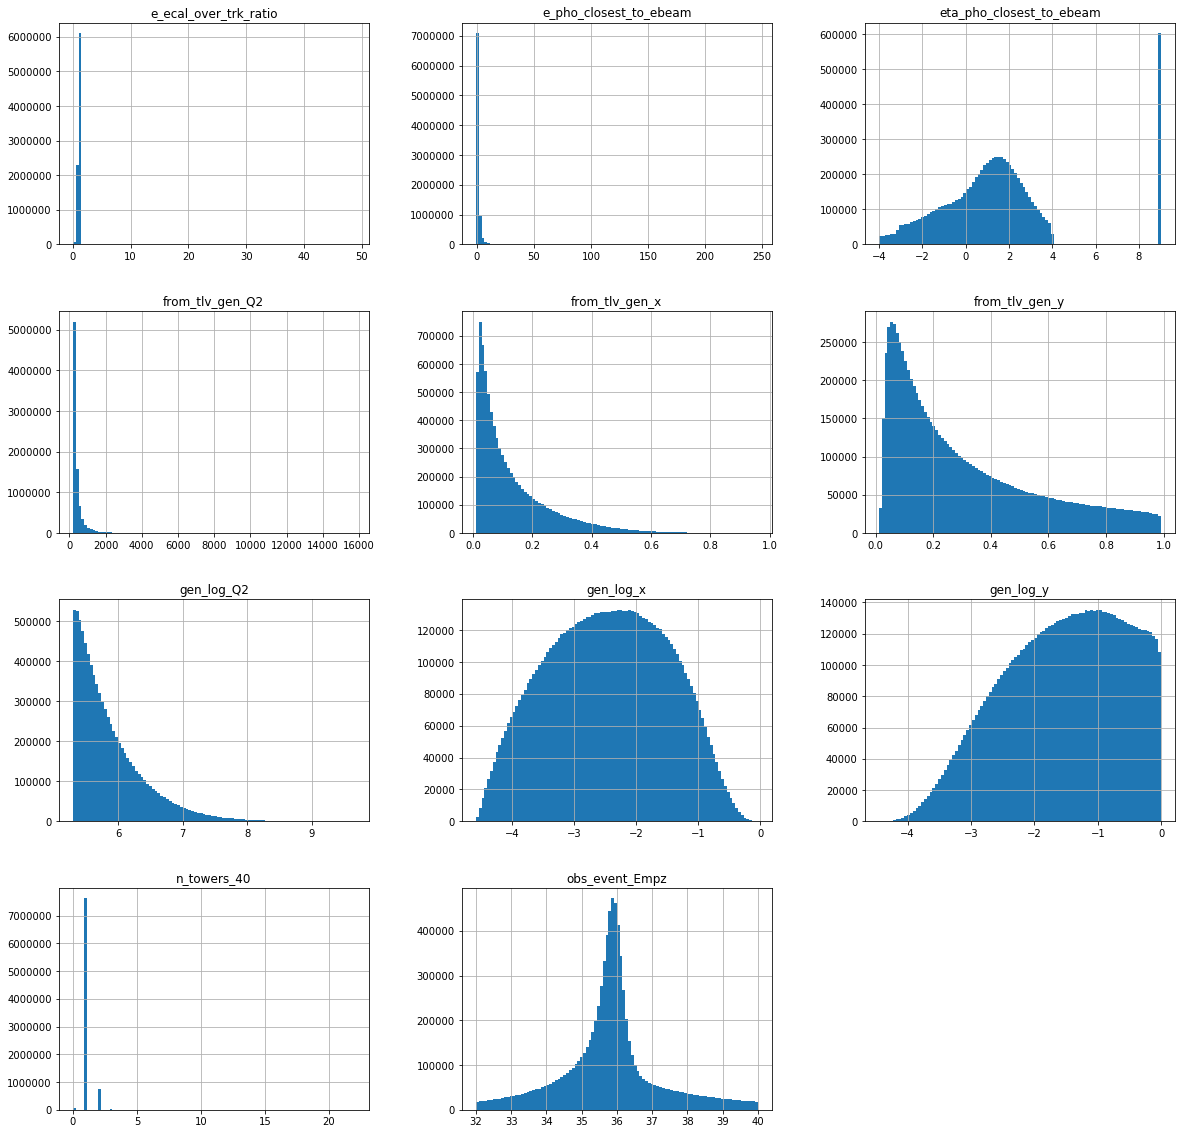

In [8]:
pandas_df.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz',
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam'])
plt.show()

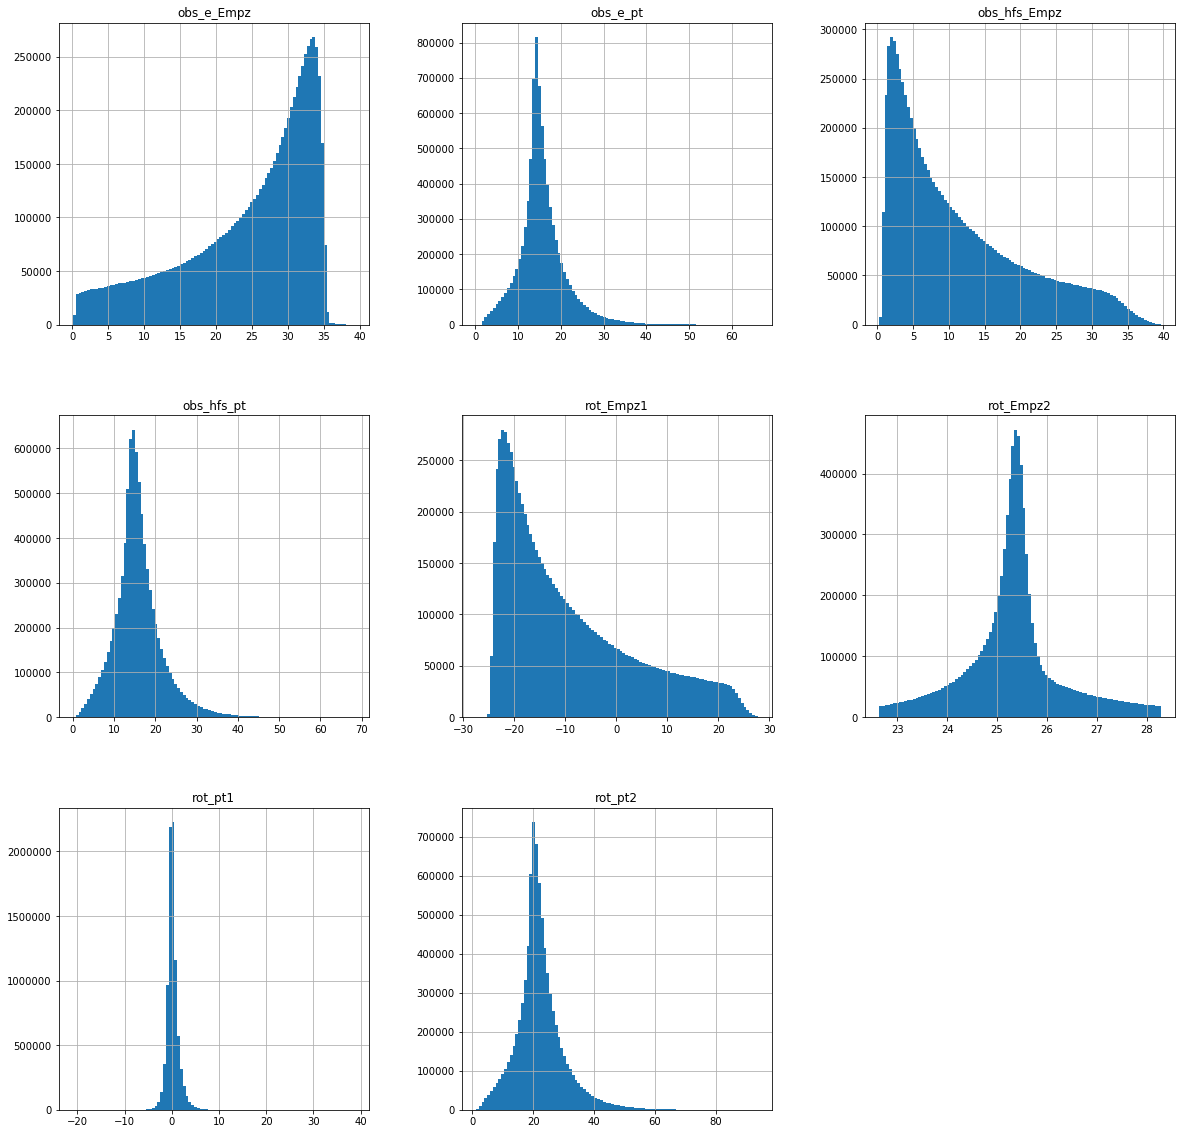

In [9]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1','rot_Empz2',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import load

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
    pandas_df['rot_Empz2'].to_numpy(),
    pandas_df['obs_dphi'].to_numpy(),
]

#-- targets for classification
Y = np.c_[ 
    pandas_df['has_norad'].to_numpy(),
    pandas_df['has_isr'].to_numpy(),
    pandas_df['has_fsr'].to_numpy(),
]

#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
]

    
GY = pandas_df['from_tlv_gen_y'].to_numpy()



#-- Load the scaler transformations!  These are essential when reusing the training with a different dataset.

scaler = load( open('%s-scalers/input_scaler.pkl' % training_name, 'rb'))
X = scaler.transform(X)


scalerY = load( open('%s-scalers/target_scaler.pkl' % training_name , 'rb'))
Y_r = scalerY.transform(Y_r)



X_train, X_test,    Y_train, Y_test,    Y_r_train, Y_r_test,    GY_train, GY_test = train_test_split( X, Y, Y_r, GY,  test_size=0.5)
    

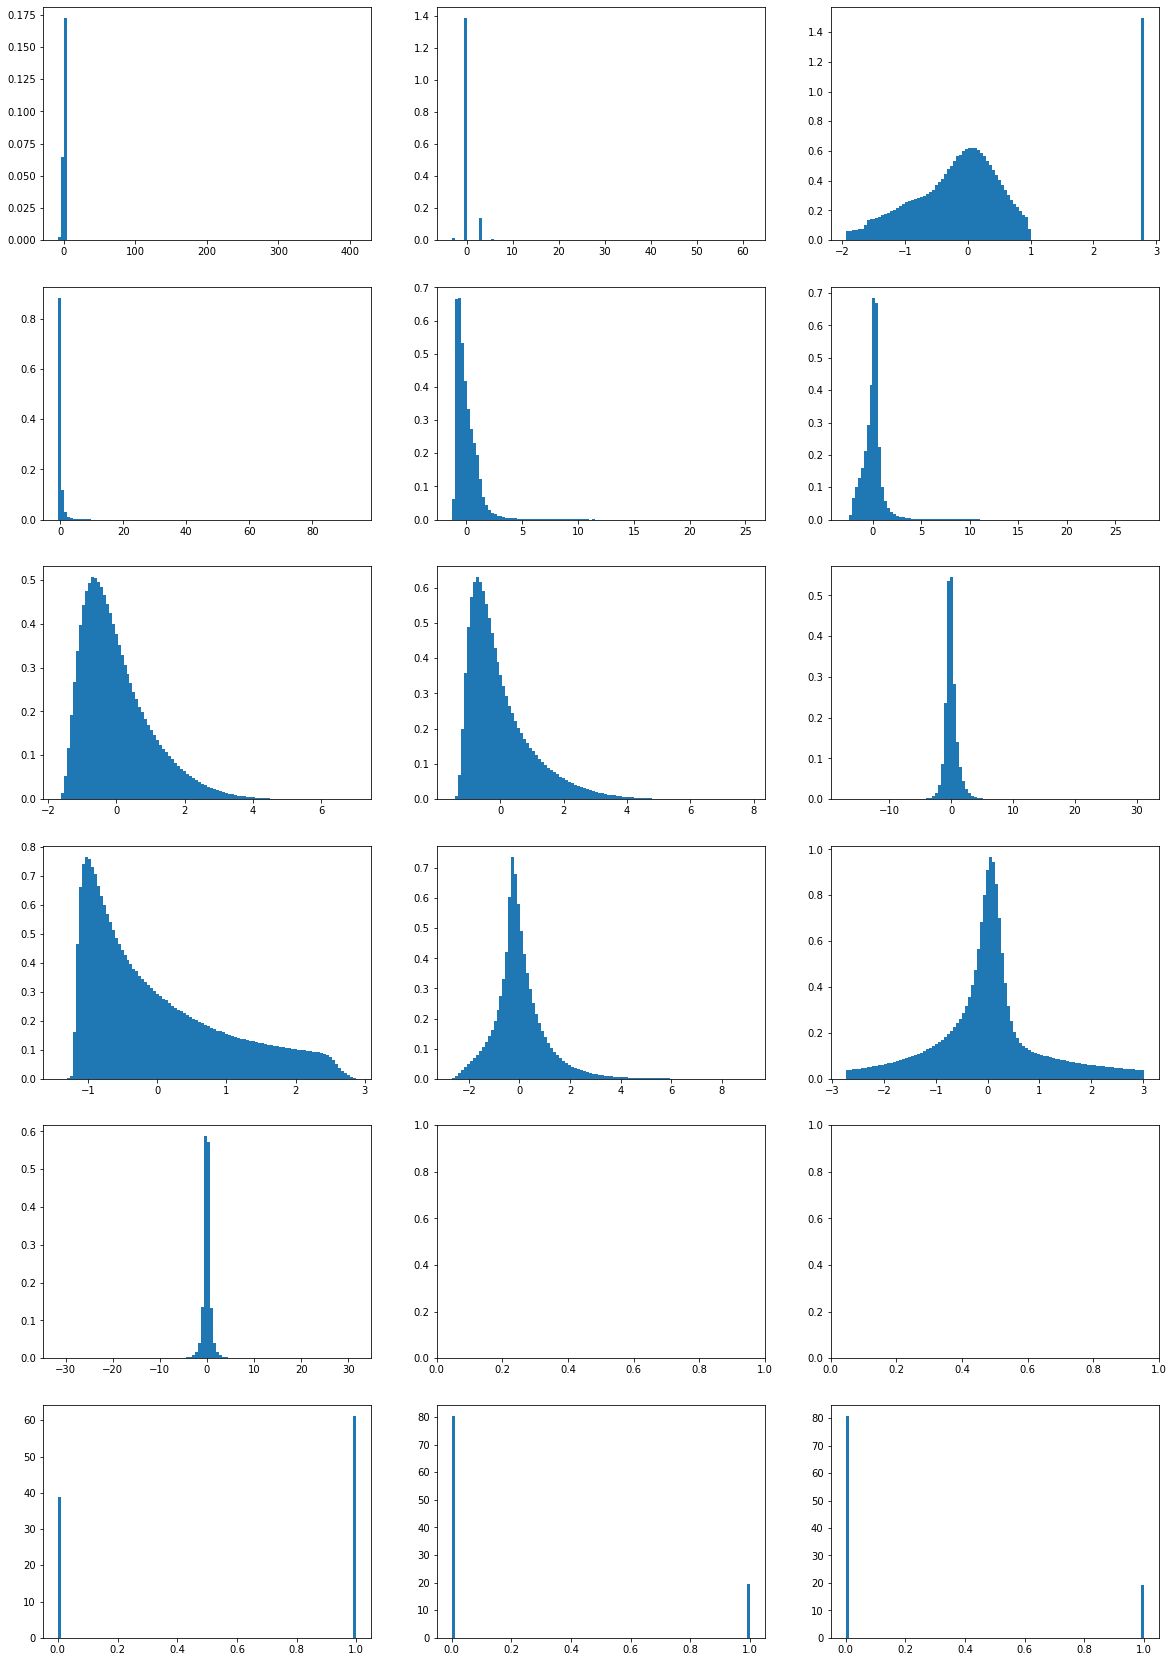

In [12]:
fig,ax = plt.subplots(6,3,figsize=(20,30))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )



ax[5][0].hist( Y[:,0], density=True, bins=100 )
ax[5][1].hist( Y[:,1], density=True, bins=100 )
ax[5][2].hist( Y[:,2], density=True, bins=100 )

plt.show()

In [13]:
model = tf.keras.models.load_model( '%s_classifier' % training_name )

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [14]:
mypreds = model.predict(X_test,batch_size=1000)

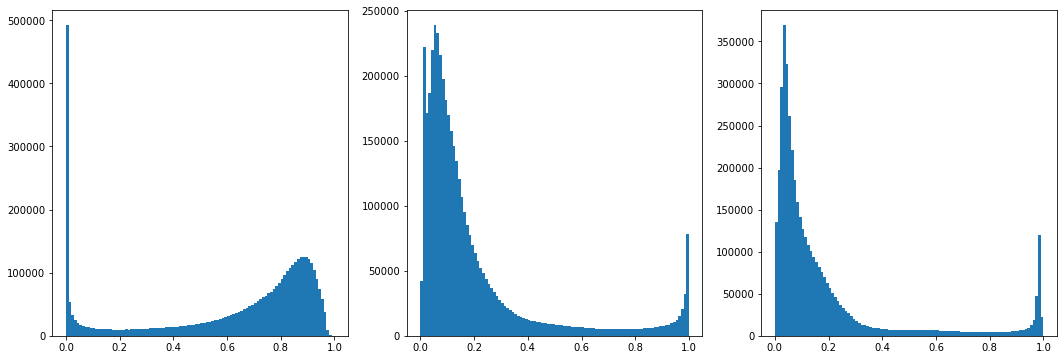

In [15]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds[:,0],bins=100, range=[0,1] )
ax[1].hist(mypreds[:,1],bins=100, range=[0,1] )
ax[2].hist(mypreds[:,2],bins=100, range=[0,1] )
plt.show()

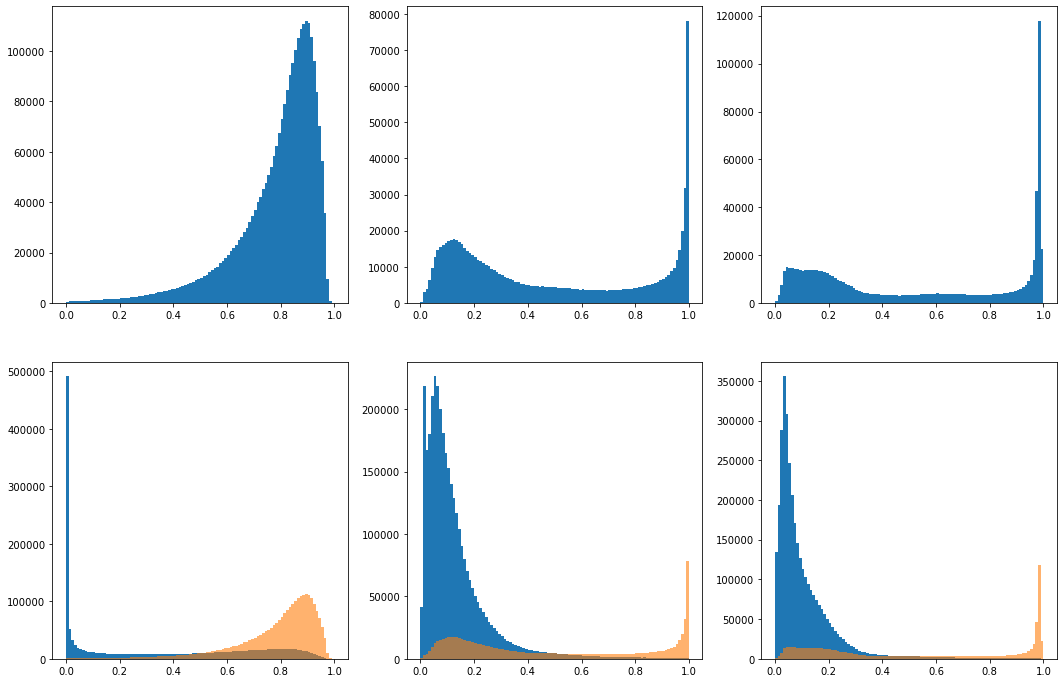

In [16]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

ax[0][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1] )
ax[0][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1] )
ax[0][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1] )

ax[1][0].hist(mypreds[:,0][Y_test[:,0]<0.5],bins=100, range=[0,1] )
ax[1][1].hist(mypreds[:,1][Y_test[:,1]<0.5],bins=100, range=[0,1] )
ax[1][2].hist(mypreds[:,2][Y_test[:,2]<0.5],bins=100, range=[0,1] )

ax[1][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1], alpha=0.6 )
ax[1][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1], alpha=0.6 )
ax[1][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1], alpha=0.6 )



plt.show()

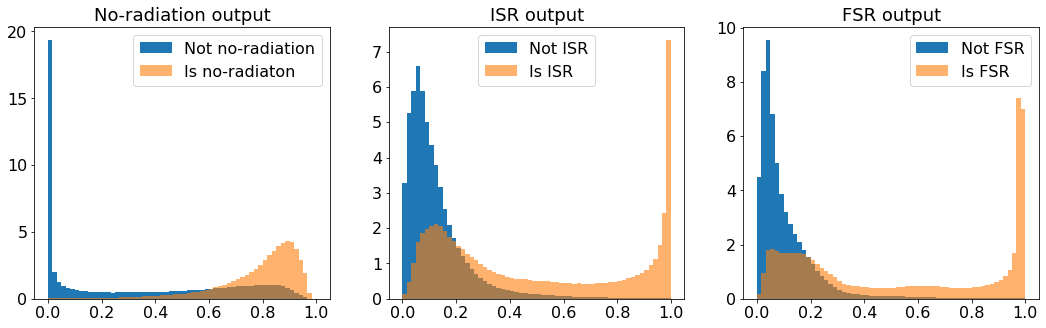

In [80]:



fig,ax = plt.subplots(1,3,figsize=(18,5))

nbins=60

ax[0].hist(mypreds[:,0][Y_test[:,0]<0.5],bins=nbins, density=True, range=[0,1], label='Not no-radiation' )
ax[1].hist(mypreds[:,1][Y_test[:,1]<0.5],bins=nbins, density=True, range=[0,1], label='Not ISR' )
ax[2].hist(mypreds[:,2][Y_test[:,2]<0.5],bins=nbins, density=True, range=[0,1], label='Not FSR' )



ax[0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=nbins, range=[0,1], density=True, alpha=0.6, label='Is no-radiaton' )
ax[1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=nbins, range=[0,1], density=True, alpha=0.6, label='Is ISR' )
ax[2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=nbins, range=[0,1], density=True, alpha=0.6, label='Is FSR' )

ax[0].set_title('No-radiation output', fontsize=18)
ax[1].set_title('ISR output', fontsize=18)
ax[2].set_title('FSR output', fontsize=18)

ax[0].legend(loc='best', fontsize=16)
ax[1].legend(loc='best', fontsize=16)
ax[2].legend(loc='best', fontsize=16)

ax[0].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='x', labelsize=16)
ax[2].tick_params(axis='x', labelsize=16)

ax[0].tick_params(axis='y', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)
ax[2].tick_params(axis='y', labelsize=16)

plt.savefig('plots/classification-dnn-output-athena.pdf', bbox_inches='tight' )

plt.show()




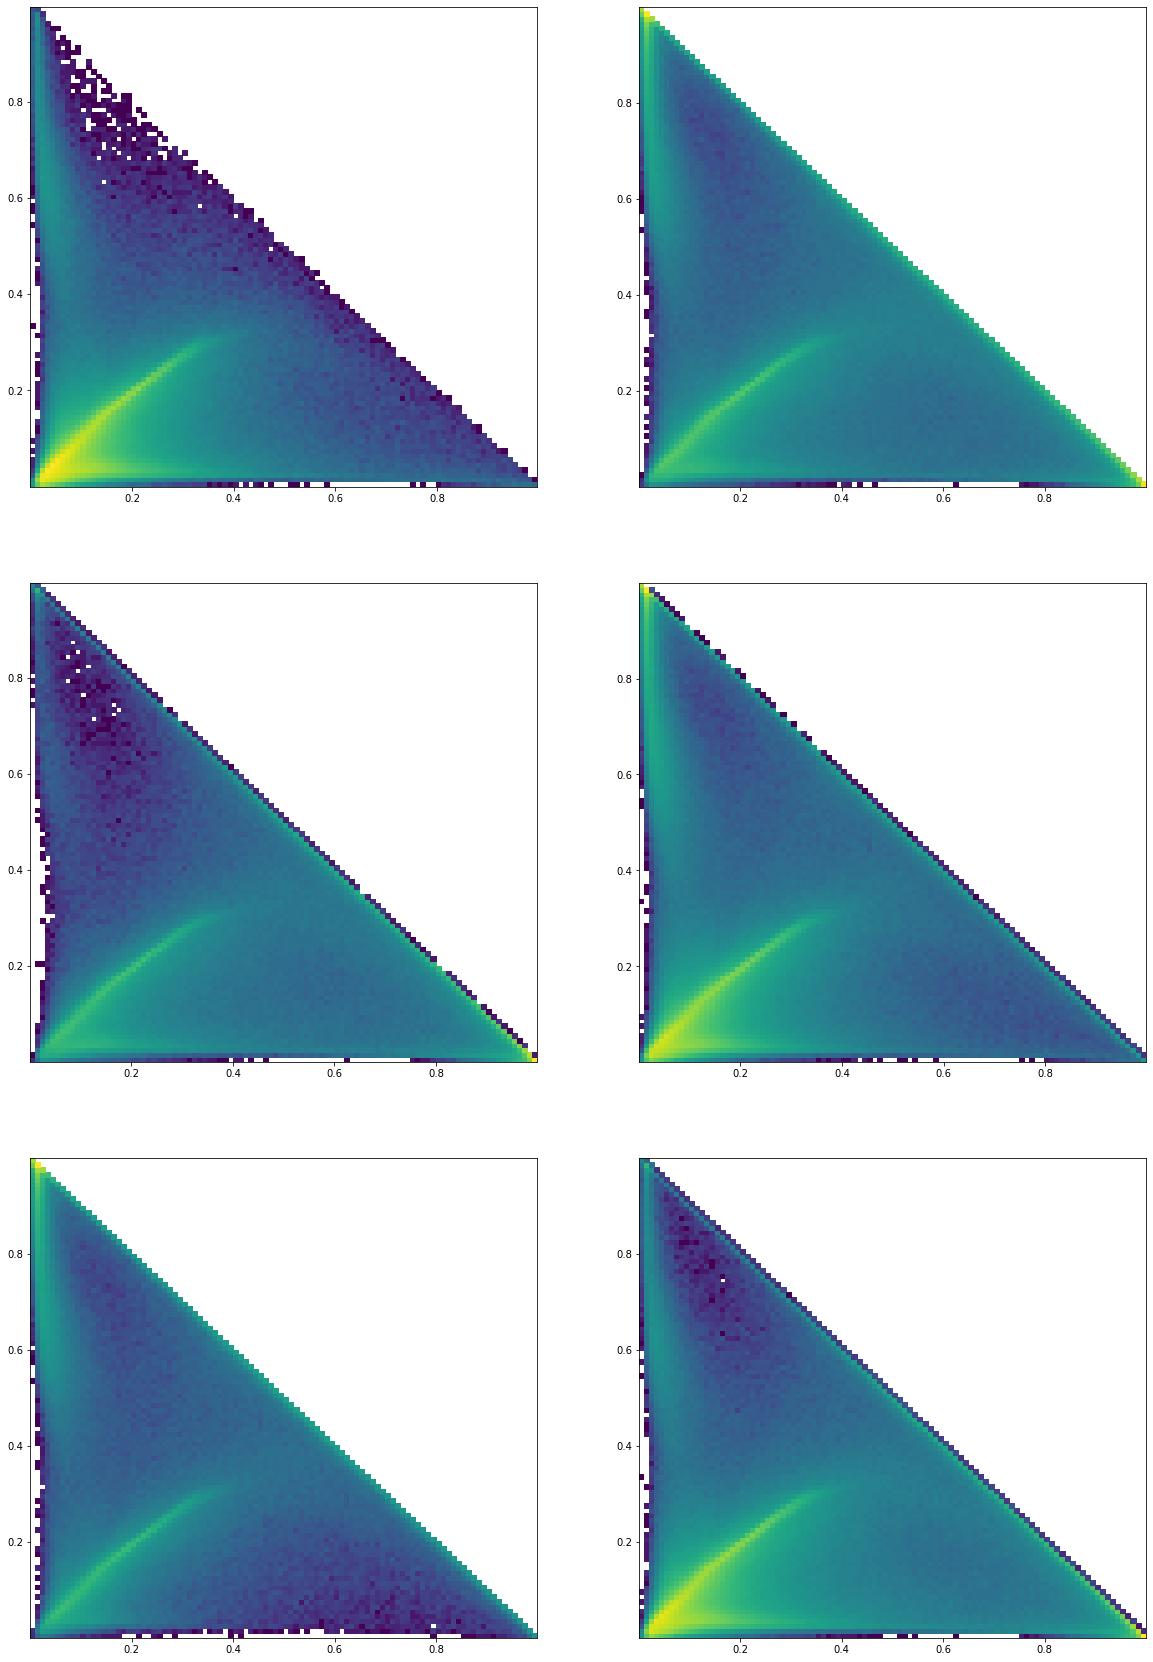

In [17]:
fig,ax = plt.subplots(3,2,figsize=(20,30))

ax[0][0].hist2d( mypreds[:,1][Y_test[:,0]>0.5], mypreds[:,2][Y_test[:,0]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[0][1].hist2d( mypreds[:,1][Y_test[:,0]<0.5], mypreds[:,2][Y_test[:,0]<0.5], bins=100, norm=mpl.colors.LogNorm())

ax[1][0].hist2d( mypreds[:,1][Y_test[:,1]>0.5], mypreds[:,2][Y_test[:,1]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[1][1].hist2d( mypreds[:,1][Y_test[:,1]<0.5], mypreds[:,2][Y_test[:,1]<0.5], bins=100, norm=mpl.colors.LogNorm())

ax[2][0].hist2d( mypreds[:,1][Y_test[:,2]>0.5], mypreds[:,2][Y_test[:,2]>0.5], bins=100, norm=mpl.colors.LogNorm())
ax[2][1].hist2d( mypreds[:,1][Y_test[:,2]<0.5], mypreds[:,2][Y_test[:,2]<0.5], bins=100, norm=mpl.colors.LogNorm())



plt.show()

In [18]:
mypreds

array([[0.8814007 , 0.05788386, 0.06071542],
       [0.75904685, 0.190943  , 0.05001011],
       [0.94126135, 0.03417714, 0.02456141],
       ...,
       [0.8368107 , 0.13552833, 0.02766096],
       [0.10427344, 0.02094761, 0.874779  ],
       [0.8131513 , 0.12230498, 0.06454372]], dtype=float32)

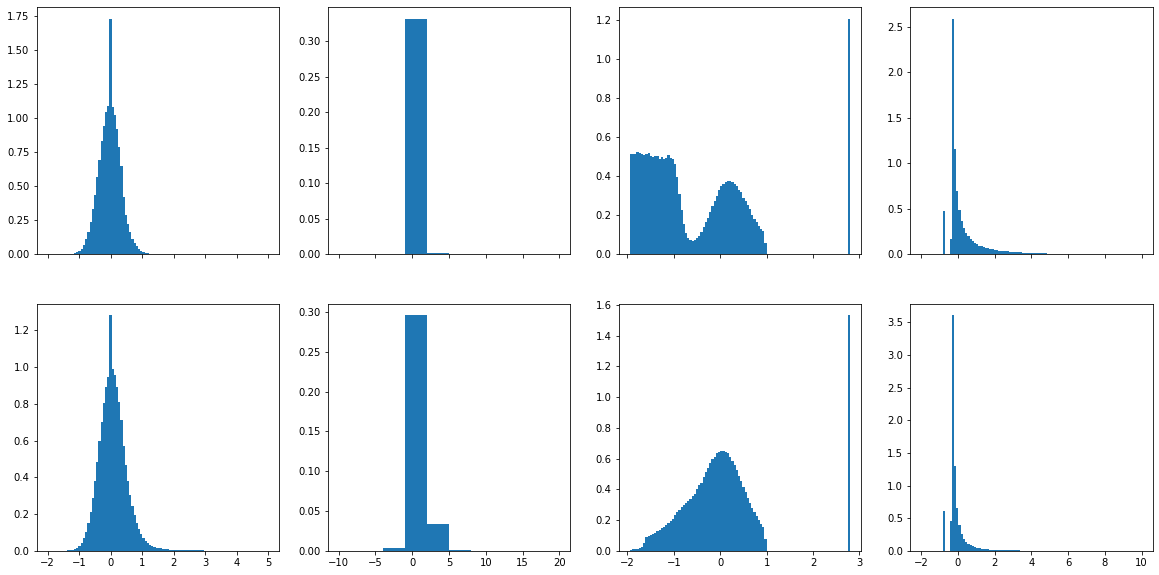

In [19]:
fig,ax = plt.subplots(2,4,figsize=(20,10), sharex='col')

ax[0][0].hist( X_test[:,0][mypreds[:,1]>0.5], density=True, range=(-2,5), bins=100 )
ax[0][1].hist( X_test[:,1][mypreds[:,1]>0.5], density=True, range=(-10,20), bins=10 )
ax[0][2].hist( X_test[:,2][mypreds[:,1]>0.5], density=True, bins=100 )
ax[0][3].hist( X_test[:,3][mypreds[:,1]>0.5], density=True, range=(-2,10), bins=100 )

ax[1][0].hist( X_test[:,0][mypreds[:,1]<0.5], density=True, range=(-2,5), bins=100 )
ax[1][1].hist( X_test[:,1][mypreds[:,1]<0.5], density=True, range=(-10,20), bins=10 )
ax[1][2].hist( X_test[:,2][mypreds[:,1]<0.5], density=True, bins=100 )
ax[1][3].hist( X_test[:,3][mypreds[:,1]<0.5], density=True, range=(-2,10), bins=100 )


plt.show()

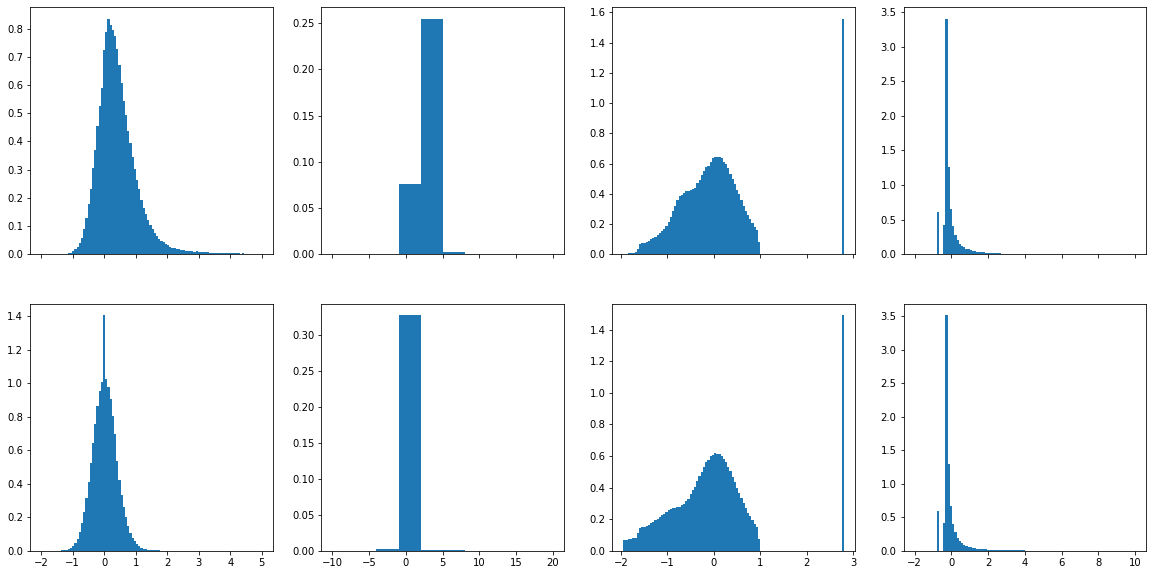

In [20]:
fig,ax = plt.subplots(2,4,figsize=(20,10), sharex='col')

ax[0][0].hist( X_test[:,0][mypreds[:,2]>0.5], density=True, range=(-2,5), bins=100 )
ax[0][1].hist( X_test[:,1][mypreds[:,2]>0.5], density=True, range=(-10,20), bins=10 )
ax[0][2].hist( X_test[:,2][mypreds[:,2]>0.5], density=True, bins=100 )
ax[0][3].hist( X_test[:,3][mypreds[:,2]>0.5], density=True, range=(-2,10), bins=100 )

ax[1][0].hist( X_test[:,0][mypreds[:,2]<0.5], density=True, range=(-2,5), bins=100 )
ax[1][1].hist( X_test[:,1][mypreds[:,2]<0.5], density=True, range=(-10,20), bins=10 )
ax[1][2].hist( X_test[:,2][mypreds[:,2]<0.5], density=True, bins=100 )
ax[1][3].hist( X_test[:,3][mypreds[:,2]<0.5], density=True, range=(-2,10), bins=100 )


plt.show()

## Now, add classification outputs to the set of inputs for the regression

In [21]:
X_train

array([[-0.0185054 , -0.26437269,  0.37386538, ...,  1.20962714,
        -0.14593245, -0.12291264],
       [ 0.43594446, -0.26437269,  2.80739347, ...,  1.59879454,
         2.53228791, -0.66309873],
       [-0.20743269, -0.26437269, -0.45385537, ...,  0.16462458,
        -1.24823779, -0.21725666],
       ...,
       [ 0.33654062, -0.26437269,  2.80739347, ...,  0.20718731,
         0.23363864,  0.25217082],
       [ 0.09897035, -0.26437269, -1.02663218, ...,  1.76544994,
         0.47479402, -0.21712434],
       [ 0.14752253, -0.26437269,  2.80739347, ...,  2.07835691,
        -0.0482655 ,  0.08550689]])

In [22]:
mypreds_train = model.predict(X_train,batch_size=1000)

In [23]:
mypreds_train

array([[5.5736274e-01, 2.4626417e-01, 1.9637308e-01],
       [8.2125235e-01, 7.7174187e-02, 1.0157349e-01],
       [6.8139797e-01, 2.6005143e-01, 5.8550548e-02],
       ...,
       [8.6635572e-01, 6.4555548e-02, 6.9088697e-02],
       [4.3750246e-04, 9.2415553e-01, 7.5406954e-02],
       [6.1368221e-01, 1.8753560e-01, 1.9878219e-01]], dtype=float32)

In [24]:
X_merged_train = np.append(X_train, mypreds_train,1)

In [25]:
X_merged_train

array([[-1.85053958e-02, -2.64372691e-01,  3.73865378e-01, ...,
         5.57362735e-01,  2.46264175e-01,  1.96373075e-01],
       [ 4.35944462e-01, -2.64372691e-01,  2.80739347e+00, ...,
         8.21252346e-01,  7.71741867e-02,  1.01573490e-01],
       [-2.07432687e-01, -2.64372691e-01, -4.53855366e-01, ...,
         6.81397974e-01,  2.60051429e-01,  5.85505478e-02],
       ...,
       [ 3.36540617e-01, -2.64372691e-01,  2.80739347e+00, ...,
         8.66355717e-01,  6.45555481e-02,  6.90886974e-02],
       [ 9.89703452e-02, -2.64372691e-01, -1.02663218e+00, ...,
         4.37502458e-04,  9.24155533e-01,  7.54069537e-02],
       [ 1.47522530e-01, -2.64372691e-01,  2.80739347e+00, ...,
         6.13682210e-01,  1.87535599e-01,  1.98782191e-01]])

In [26]:
X_test

array([[ 0.21355338, -0.26437269,  0.17503059, ...,  2.8797873 ,
        -0.14368632,  0.00633316],
       [-0.0850142 , -0.26437269,  0.7298042 , ..., -0.64941498,
        -0.58296918,  0.95386544],
       [ 0.19172469, -0.26437269, -0.05372123, ..., -0.46966144,
         0.27940188,  0.46546187],
       ...,
       [ 0.02514332, -0.26437269, -1.432233  , ..., -1.61891384,
         0.54895132, -0.06075196],
       [ 0.14065165,  2.68433044, -0.39129318, ..., -0.20514845,
         0.98829826,  0.47180087],
       [ 0.02513924, -0.26437269, -1.19907969, ..., -1.08973762,
         2.36705451,  1.01201582]])

In [27]:
mypreds

array([[0.8814007 , 0.05788386, 0.06071542],
       [0.75904685, 0.190943  , 0.05001011],
       [0.94126135, 0.03417714, 0.02456141],
       ...,
       [0.8368107 , 0.13552833, 0.02766096],
       [0.10427344, 0.02094761, 0.874779  ],
       [0.8131513 , 0.12230498, 0.06454372]], dtype=float32)

In [28]:
X_merged_test = np.append(X_test, mypreds,1)

In [29]:
X_merged_test

array([[ 0.21355338, -0.26437269,  0.17503059, ...,  0.8814007 ,
         0.05788386,  0.06071542],
       [-0.0850142 , -0.26437269,  0.7298042 , ...,  0.75904685,
         0.190943  ,  0.05001011],
       [ 0.19172469, -0.26437269, -0.05372123, ...,  0.94126135,
         0.03417714,  0.02456141],
       ...,
       [ 0.02514332, -0.26437269, -1.432233  , ...,  0.83681071,
         0.13552833,  0.02766096],
       [ 0.14065165,  2.68433044, -0.39129318, ...,  0.10427344,
         0.02094761,  0.87477899],
       [ 0.02513924, -0.26437269, -1.19907969, ...,  0.8131513 ,
         0.12230498,  0.06454372]])

In [30]:
len(X_merged_test[0])

16

## Set up the regression network

In [31]:
model_r = tf.keras.models.load_model('%s_regression' % training_name )
model_r.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

In [32]:
mypreds_r = model_r.predict(X_merged_test,batch_size=1000)

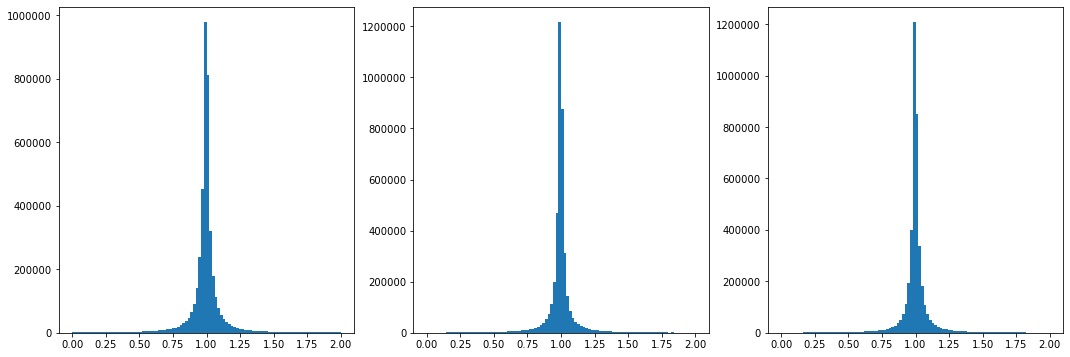

In [33]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

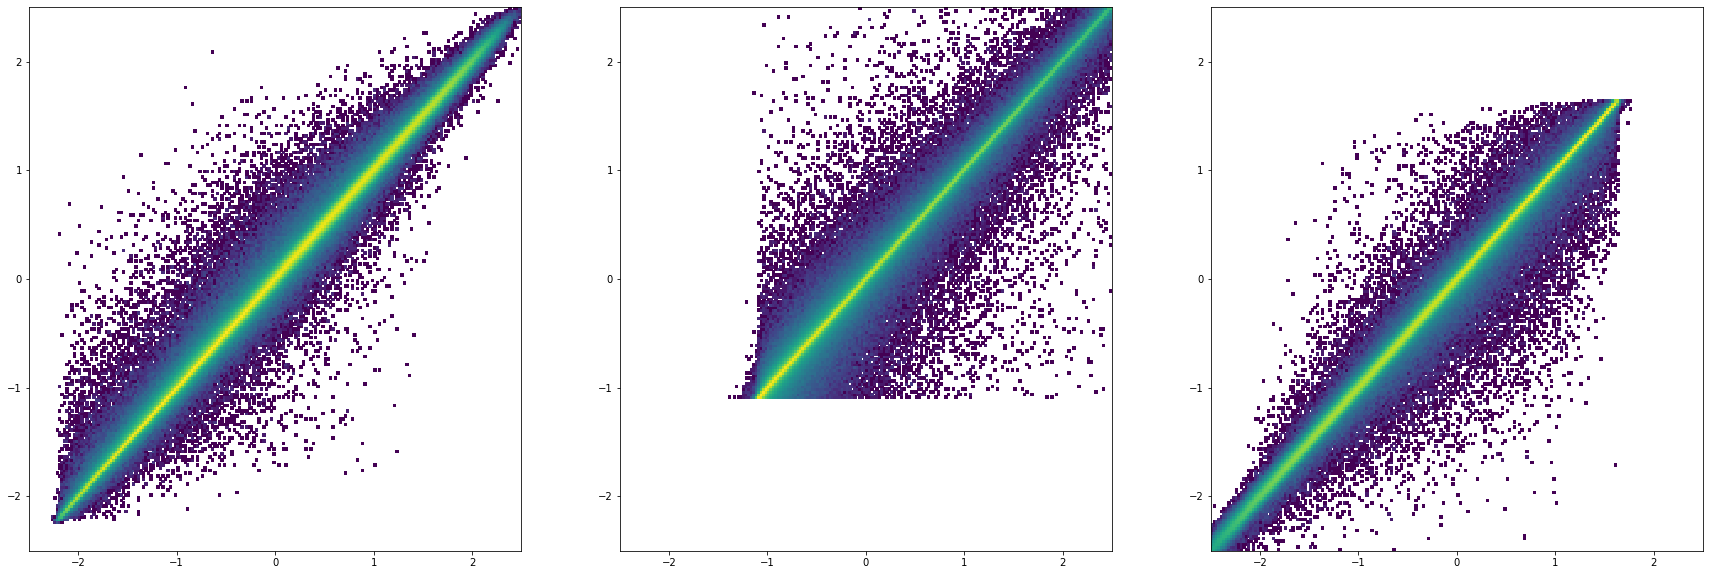

In [34]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [35]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

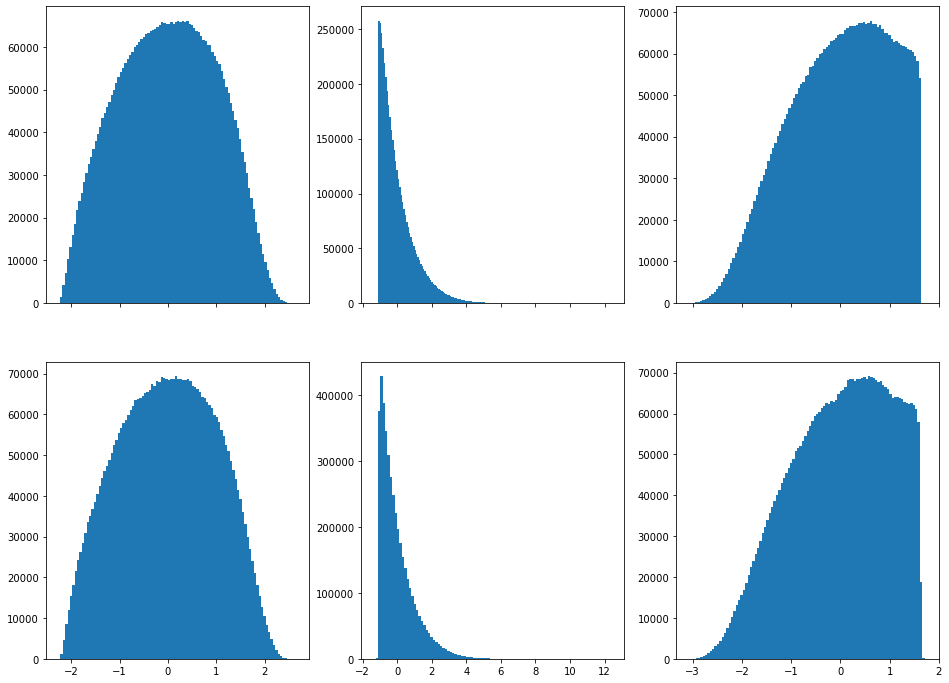

In [36]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

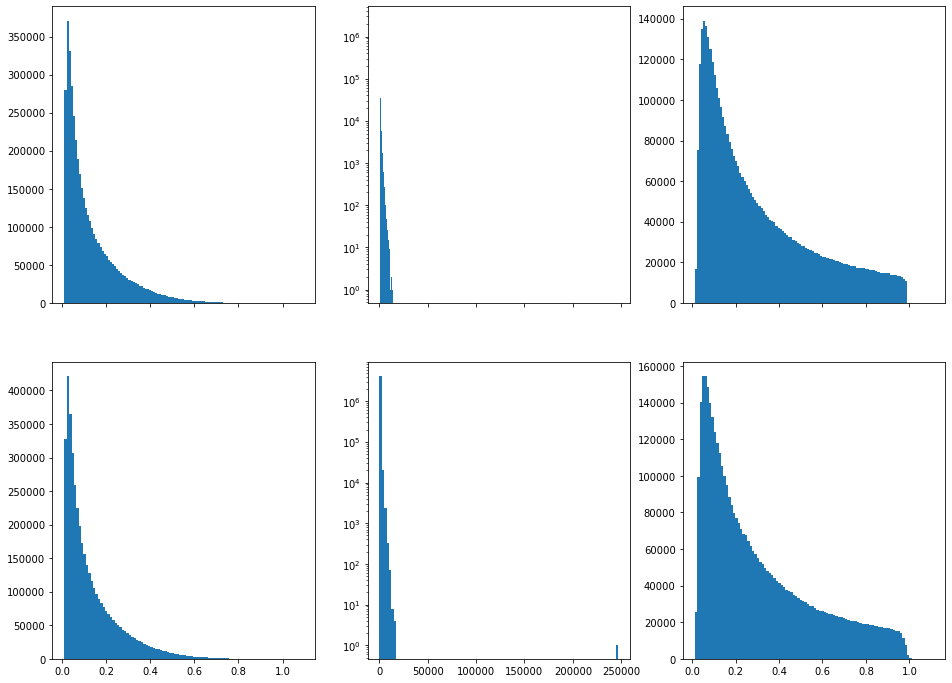

In [37]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

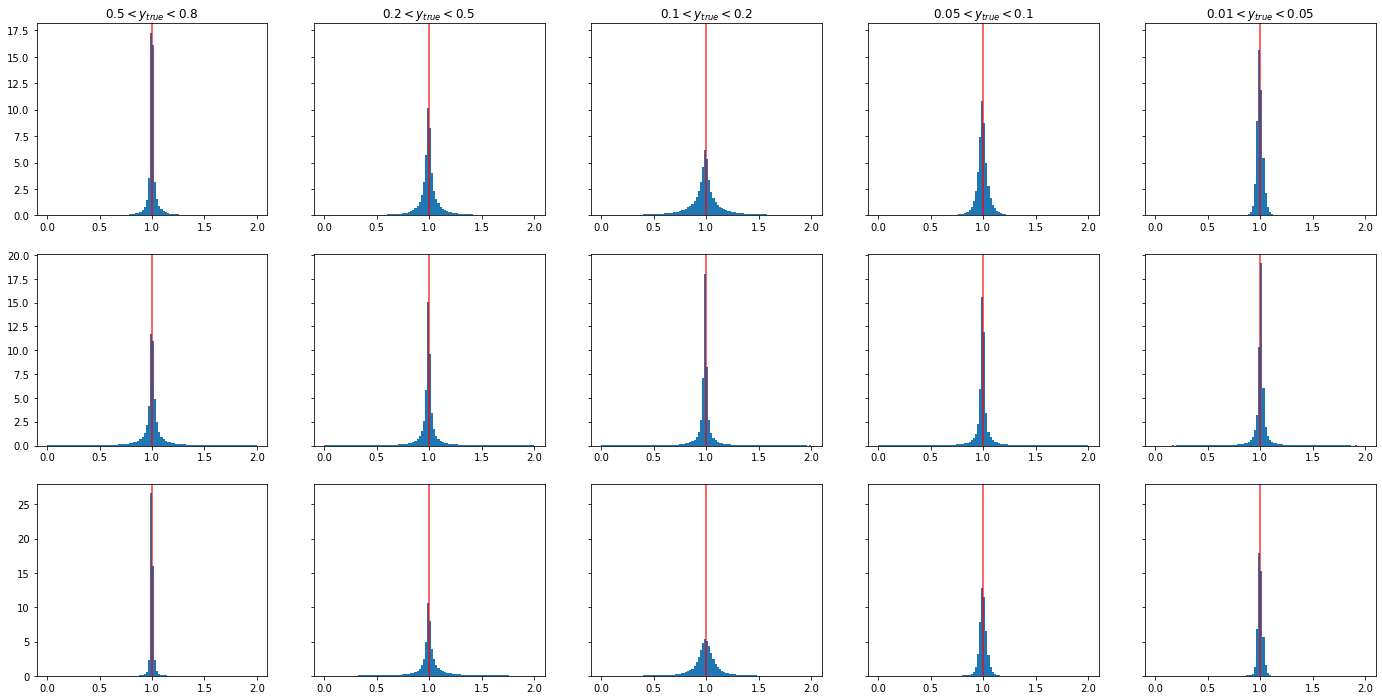

In [38]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


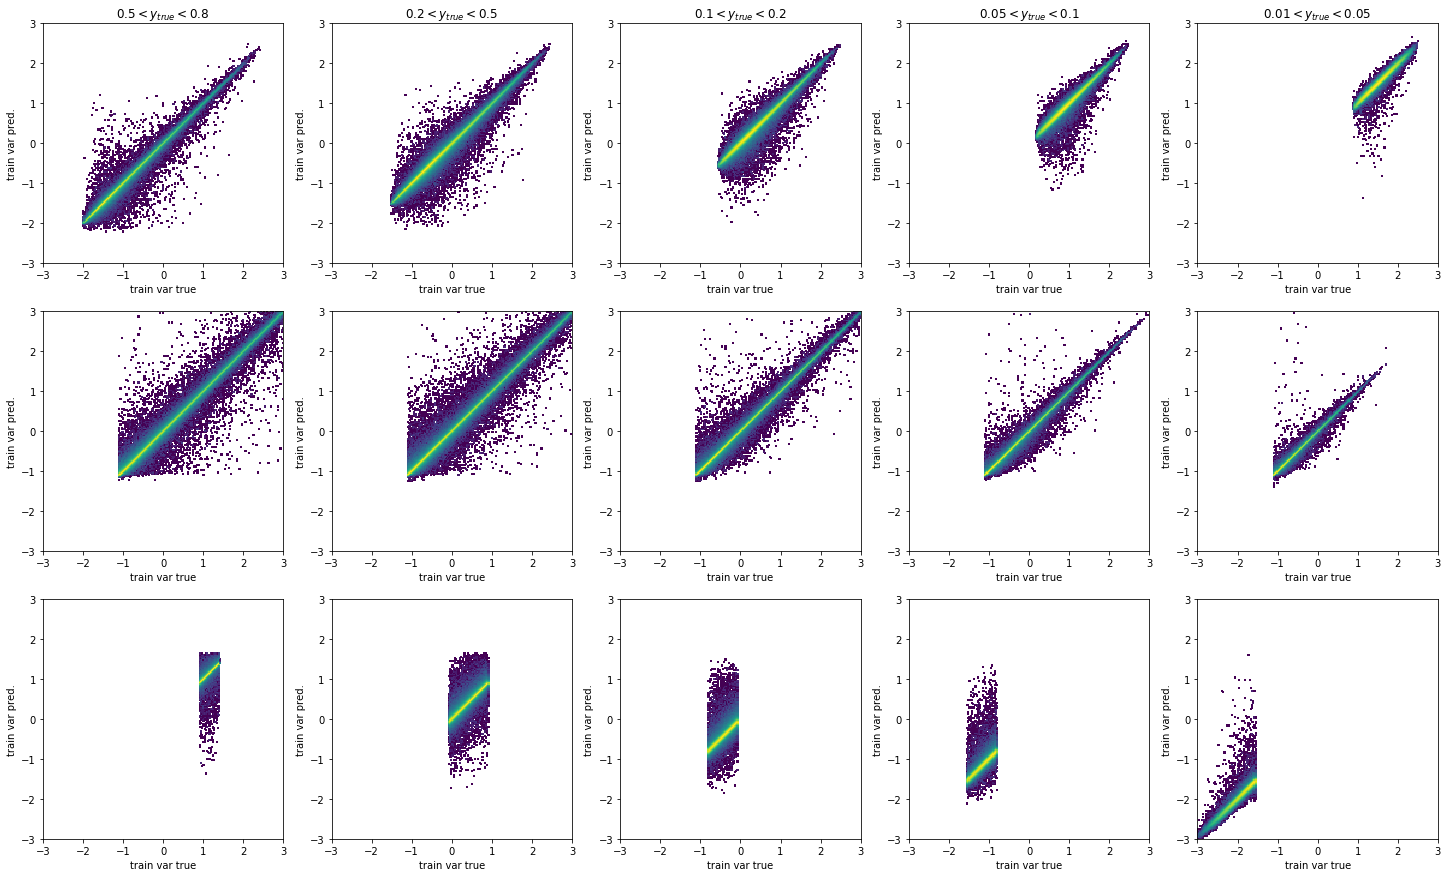

In [39]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

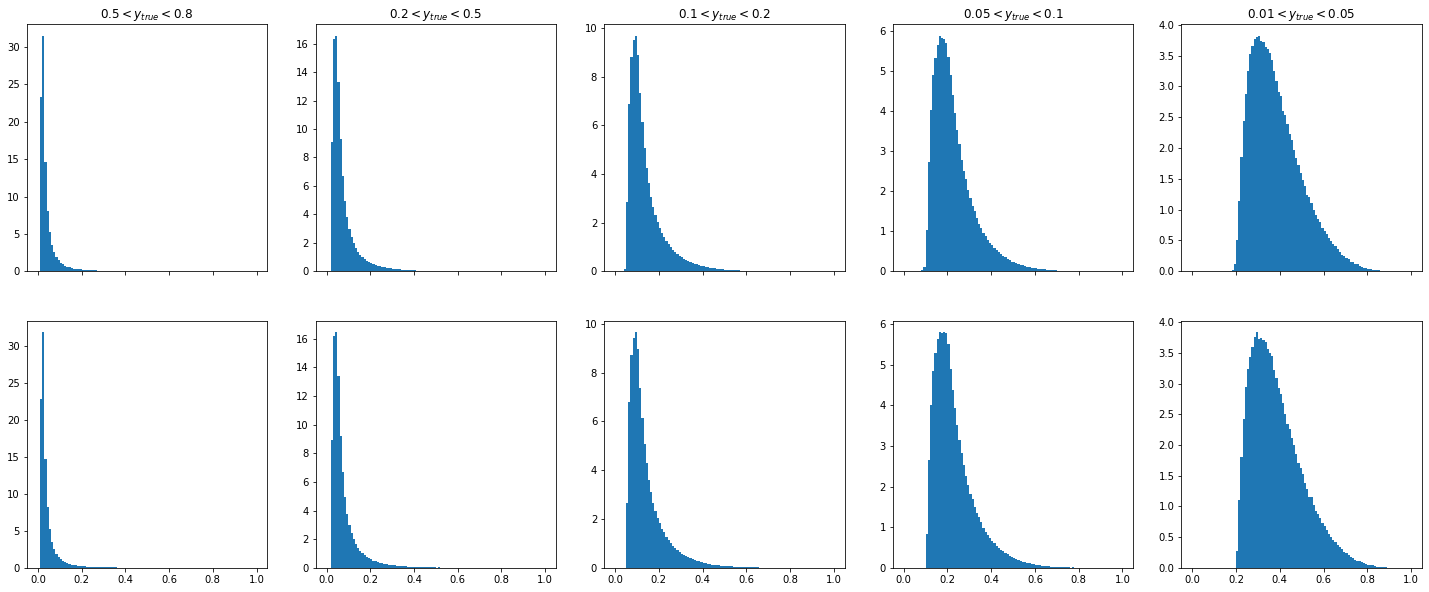

In [40]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

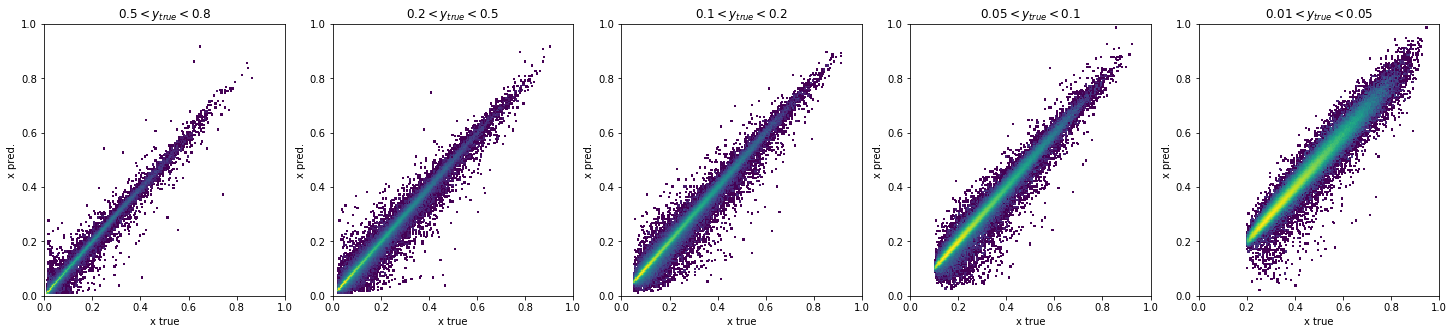

In [41]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

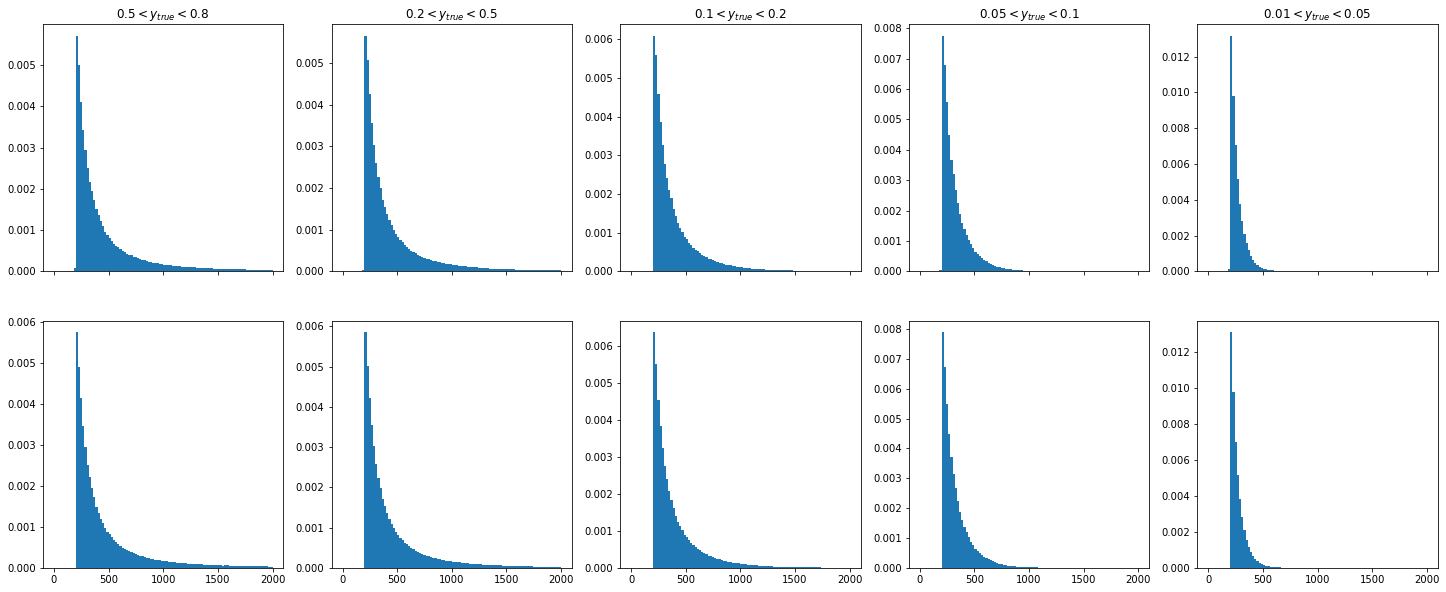

In [42]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

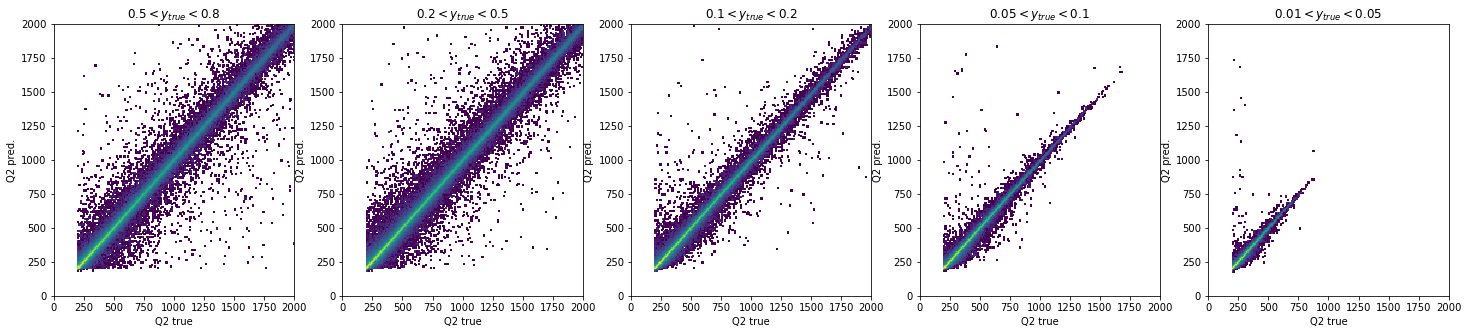

In [43]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

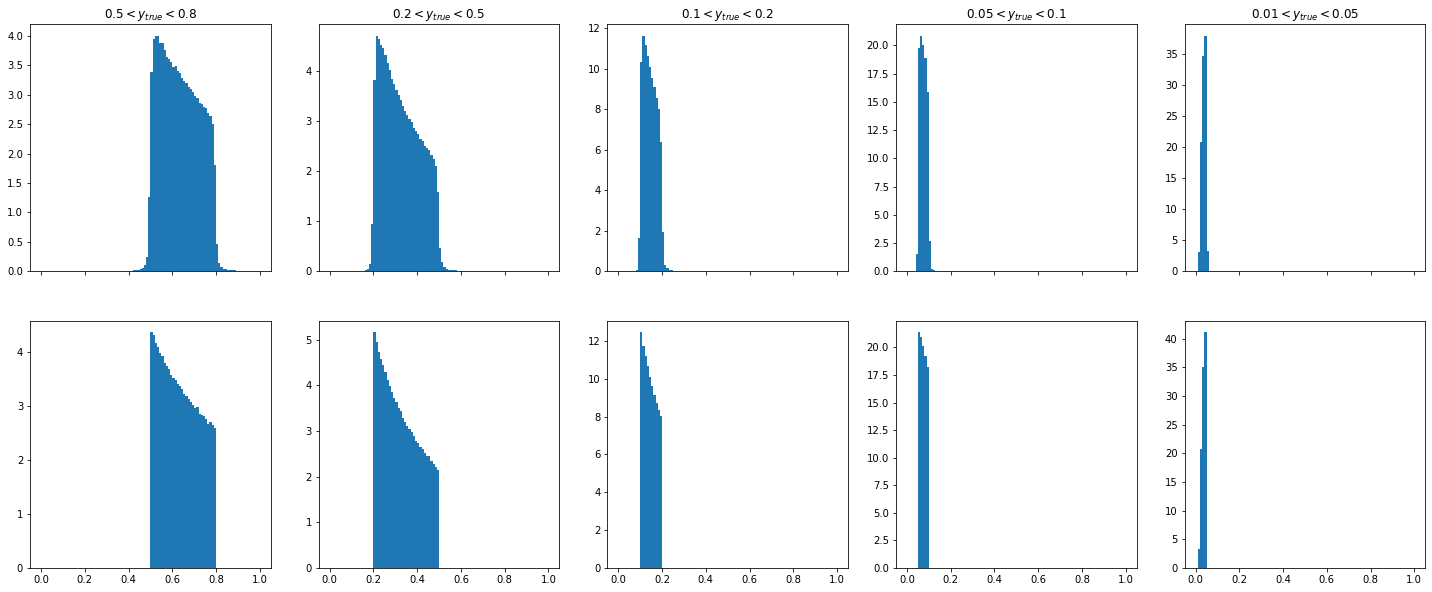

In [44]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

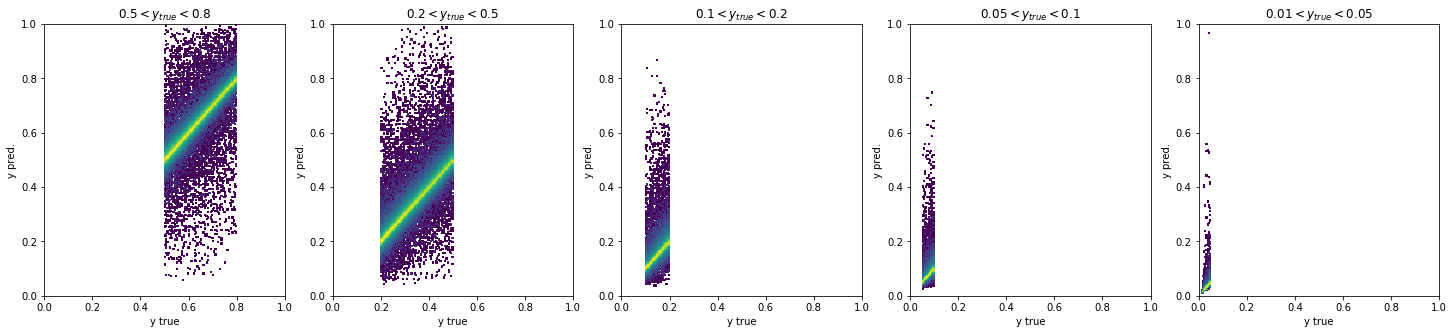

In [45]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

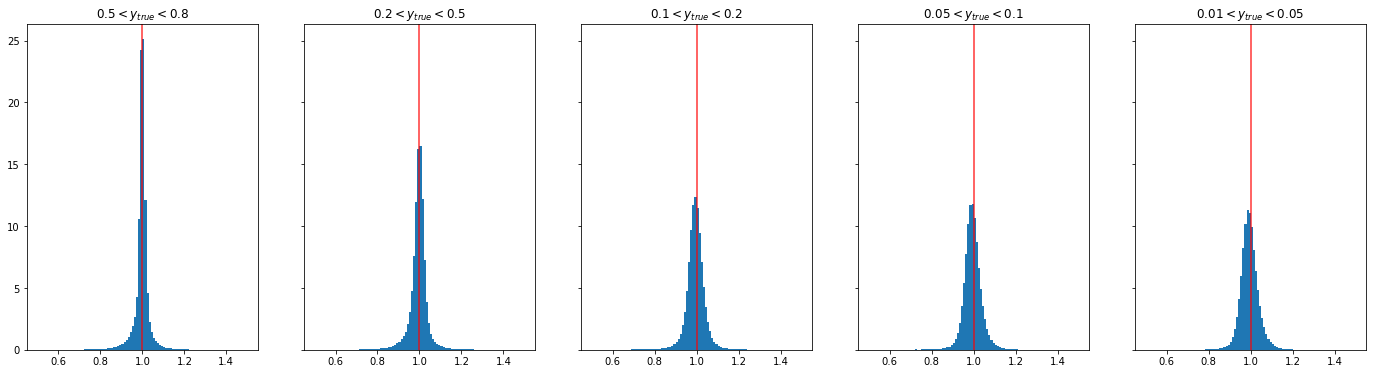

In [46]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

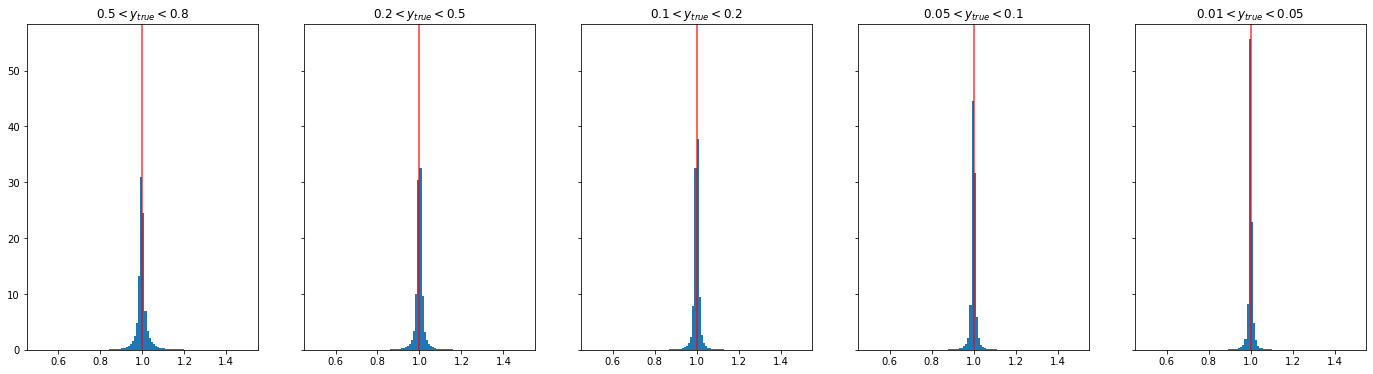

In [47]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

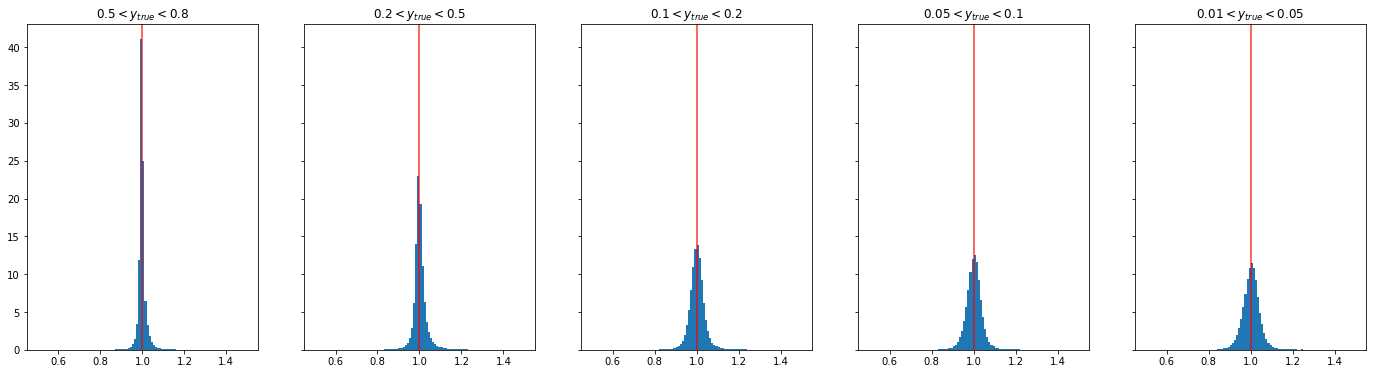

In [48]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

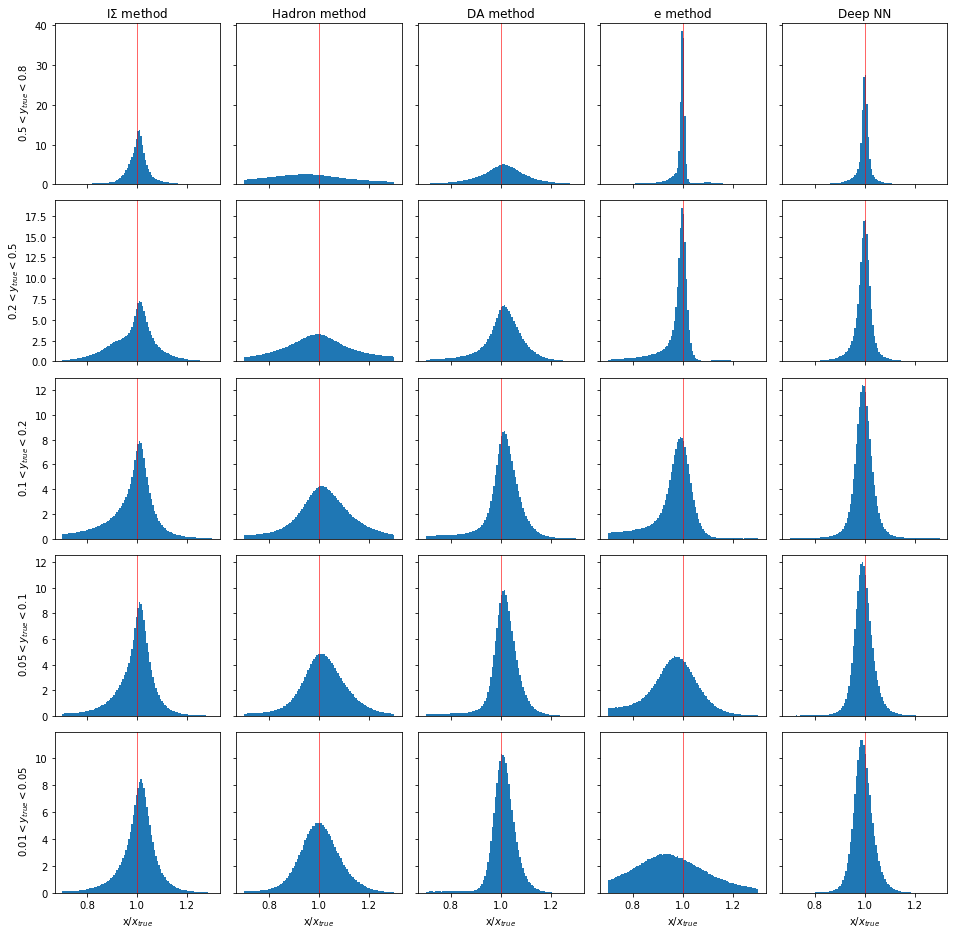

In [49]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.7
xmax = 1.3

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0       
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_x[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
if save_plots :
    plt.savefig('plots/deepNN-x-resolution-ATHENA-Q2gt200-CthenR-%s.pdf' % plot_string, bbox_inches='tight' )
    plt.savefig('plots/deepNN-x-resolution-ATHENA-Q2gt200-CthenR-%s.png' % plot_string, bbox_inches='tight' )
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)


## resolution in Q2

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

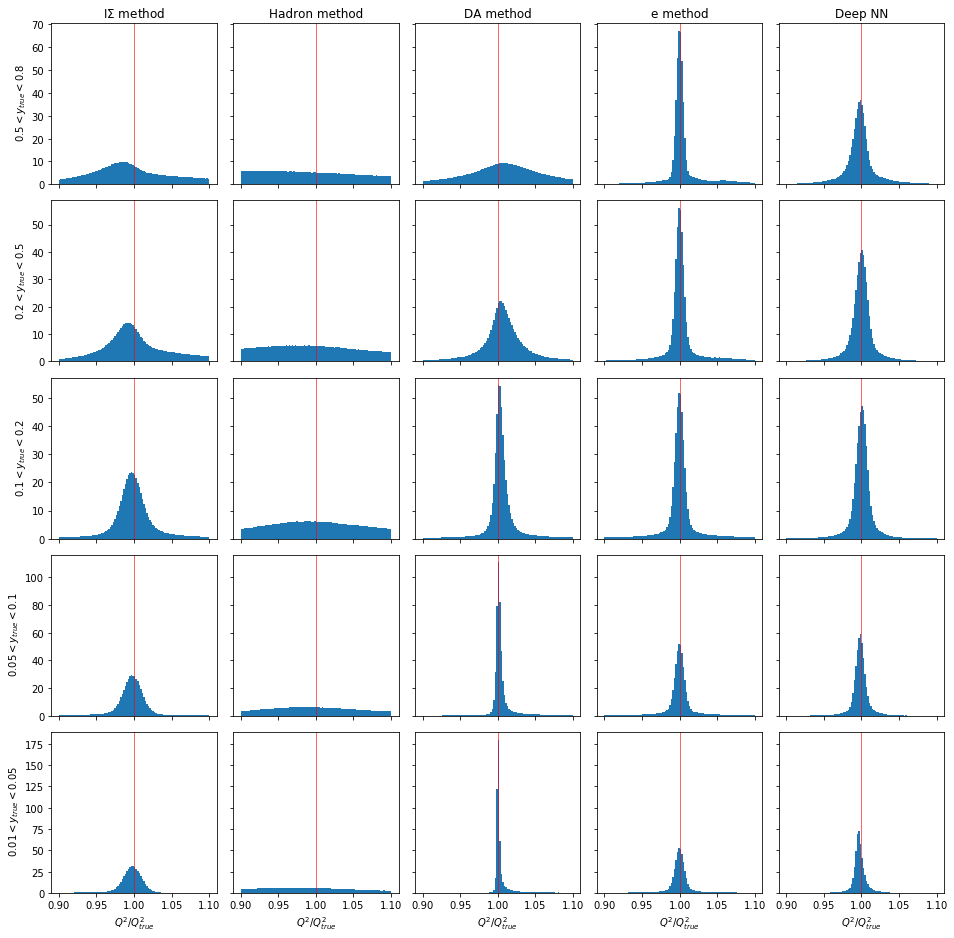

In [50]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

xmin = 0.90
xmax = 1.10


if xaxis_range == 'medium':
    xmin = 0.6
    xmax = 1.4    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0  
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
if save_plots :
    plt.savefig('plots/deepNN-Q2-resolution-ATHENA-Q2gt200-CthenR-%s.pdf' % plot_string, bbox_inches='tight' )
    plt.savefig('plots/deepNN-Q2-resolution-ATHENA-Q2gt200-CthenR-%s.png' % plot_string, bbox_inches='tight' )
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Resolution in y

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

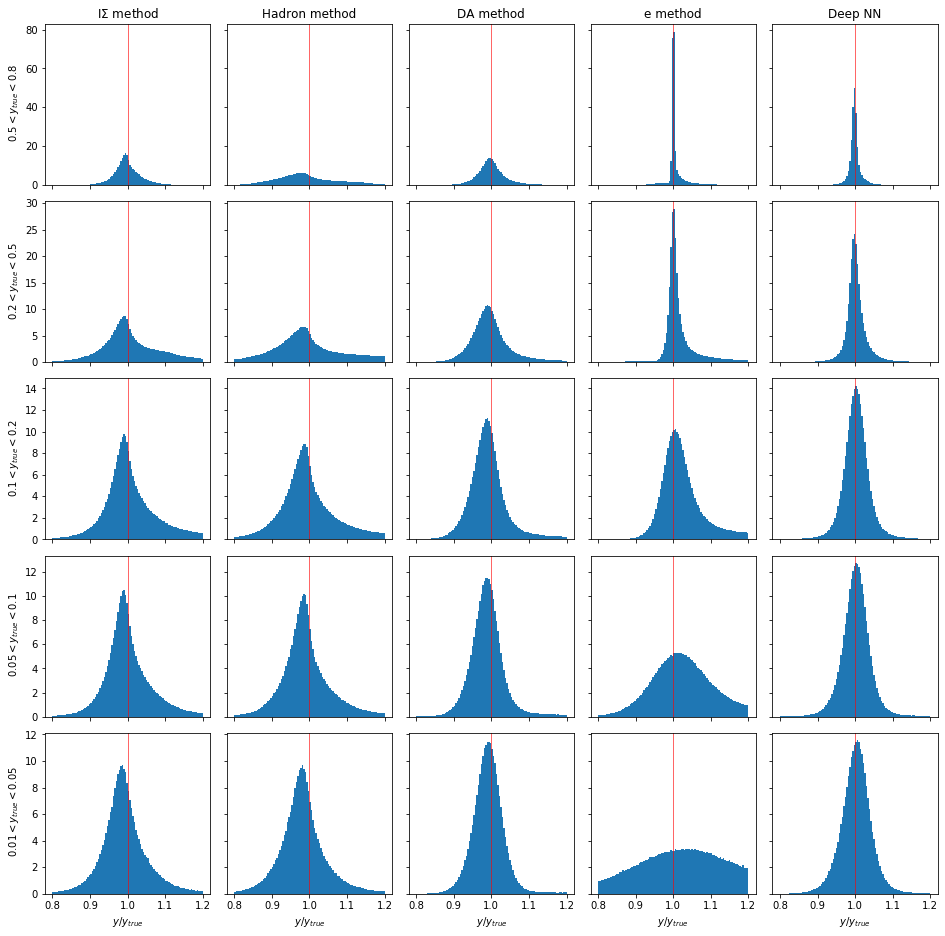

In [51]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.8
xmax = 1.2

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5
    
if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0  

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_y[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_y'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
if save_plots :
    plt.savefig('plots/deepNN-y-resolution-ATHENA-Q2gt200-CthenR-%s.pdf' % plot_string, bbox_inches='tight' )
    plt.savefig('plots/deepNN-y-resolution-ATHENA-Q2gt200-CthenR-%s.png' % plot_string, bbox_inches='tight' )


        
plt.subplots_adjust(wspace=0.1, hspace=0.1)